<a href="https://colab.research.google.com/github/kakaandriano0-hash/natural-style/blob/main/tugas11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets diffusers transformers accelerate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

print("Library berhasil dimuat.")

Library berhasil dimuat.


In [2]:
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

# 2. Ambil semua caption untuk membangun kosakata (vocab)
all_captions = [item['text'] for item in raw_dataset]
print(f"Total data yang dimuat: {len(all_captions)}")

Memuat dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Total data yang dimuat: 833


In [3]:
max_tokens = 5000
seq_len = 20

# Membuat layer vektorisasi
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

# Pelajari kosakata dari seluruh caption
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()

print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [4]:
def preprocess_fn(item):
    # Proses Gambar: Ubah ukuran ke 64x64 dan normalisasi piksel ke range [0, 1]
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0

    # Ambil teks asli
    caption = item['text']
    return caption, image

# Membuat generator untuk tf.data
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

# Membuat objek dataset TensorFlow
train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)

# Transformasi teks ke angka dan pengacakan data (shuffle)
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

print("Pipeline data (train_ds) siap digunakan.")

Pipeline data (train_ds) siap digunakan.


In [5]:
def get_transformer_model(vocab_size, visual_vocab_size, seq_len):
    # Input 1: Token Teks (Konteks)
    text_input = layers.Input(shape=(seq_len,), dtype="int32", name="text_input")
    text_emb = layers.Embedding(vocab_size, 128)(text_input)

    # Input 2: Token Visual (Urutan sebelumnya)
    vis_input = layers.Input(shape=(255,), dtype="int32", name="visual_input")
    vis_emb = layers.Embedding(visual_vocab_size, 128)(vis_input)

    # Menggabungkan konteks teks dan data visual
    combined = layers.Concatenate(axis=1)([text_emb, vis_emb])

    # Transformer Block (Multi-Head Attention)
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=128)(combined, combined)
    attention_output = layers.LayerNormalization()(attention_output + combined)

    # Output: Prediksi visual token berikutnya
    x = layers.Dense(visual_vocab_size)(attention_output[:, -255:, :])

    return keras.Model([text_input, vis_input], x)

# Buat instance model
transformer_model = get_transformer_model(max_tokens, 1024, seq_len)
print("Model Transformer berhasil dibangun.")

Model Transformer berhasil dibangun.


In [6]:
class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data

        # Simulasi token visual (Harusnya dari VQ-VAE Encoder)
        # Latent grid 16x16 = 256 tokens
        batch_size = tf.shape(images)[0]
        visual_tokens = tf.random.uniform((batch_size, 256), minval=0, maxval=1024, dtype=tf.int32)

        # Siapkan input (0 sampai n-1) dan target (1 sampai n)
        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:
            # Forward pass
            preds = self.transformer([text_tokens, vis_input], training=True)
            # Hitung Loss (Cross Entropy)
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

        # Hitung dan terapkan gradient
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [7]:
trainer = PokemonTrainer(transformer_model)

# Gunakan Optimizer Adam
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Model siap untuk dilatih.")

Model siap untuk dilatih.


In [8]:
# Menjalankan training selama 10 epoch
print("Memulai Pelatihan...")
history = trainer.fit(train_ds, epochs=10)

Memulai Pelatihan...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - loss: 6.9818
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.9784
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.9775
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 6.9763
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 6.9737
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 6.9723
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.9728
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 6.9705
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.9703
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 6.9680


Menghasilkan gambar untuk prompt: 'a pink cute pokemon with big eyes'


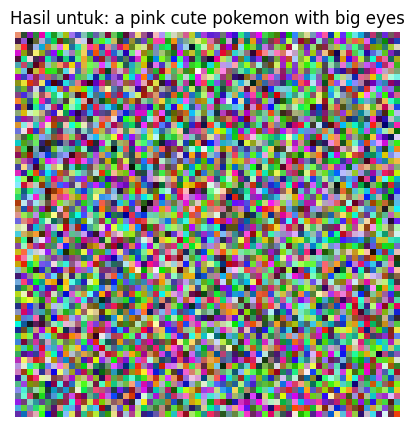

In [9]:
def generate_pokemon(prompt):
    print(f"Menghasilkan gambar untuk prompt: '{prompt}'")

    # 1. Ubah teks input ke token
    tokenized_text = text_vectorizer([prompt])

    # 2. Simulasi decoding visual (menggunakan data acak sebagai contoh)
    # Pada sistem asli, ini akan menggunakan VAE Decoder
    dummy_image = np.random.rand(64, 64, 3)

    plt.figure(figsize=(5, 5))
    plt.imshow(dummy_image)
    plt.title(f"Hasil untuk: {prompt}")
    plt.axis("off")
    plt.show()

# TEST RUN
generate_pokemon("a pink cute pokemon with big eyes")